In [ ]:
# Install required packages
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install numpy pandas scipy pydicom tqdm scikit-learn imageio opencv-python seaborn pillow matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-d2t3846s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-d2t3846s
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import clip
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from scipy.spatial import distance
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score
import glob
from sklearn.model_selection import train_test_split
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')


100%|██████████| 5.20G/5.20G [03:59<00:00, 23.3MB/s]

Extracting files...


Data source import complete.


In [ ]:
# Define the list of words as used in the paper
words = [
    'dark', 'light',
    'round', 'pointed',
    'large', 'small',
    'smooth', 'coarse',
    'transparent', 'opaque',
    'symmetric', 'asymmetric',
    'high contrast', 'low contrast'
]

# Adding some melanoma-specific words that might be relevant
skin_specific_words = [
    'irregular', 'regular',
    'mottled', 'uniform',
    'bordered', 'fuzzy',
    'spotty', 'solid',
    'multicolored', 'single-colored'
]

# Combine word lists - we'll test both the original paper words and the extended set
all_words = words + skin_specific_words

In [ ]:
def load_ham10000_data(binary_classification=True):
    """
    Load the HAM10000 dataset from the image files and metadata

    Args:
        binary_classification: If True, convert to binary classification problem
            (melanoma vs. nevi)

    Returns:
        train_data, test_data: Tuples of (image_paths, labels)
    """
    # Load the metadata
    metadata_path = kmader_skin_cancer_mnist_ham10000_path + "/HAM10000_metadata.csv"
    metadata_df = pd.read_csv(metadata_path)

    print(f"Total samples in HAM10000: {len(metadata_df)}")

    # Get counts of each diagnosis
    diagnosis_counts = metadata_df['dx'].value_counts()
    print("\nClass distribution:")
    for dx, count in diagnosis_counts.items():
        print(f"{dx}: {count} samples")

    # Find all image files
    image_dir1 = kmader_skin_cancer_mnist_ham10000_path + "/ham10000_images_part_1"
    image_dir2 = kmader_skin_cancer_mnist_ham10000_path + "/ham10000_images_part_2"

    image_paths = []
    image_paths.extend(glob.glob(os.path.join(image_dir1, "*.jpg")))
    image_paths.extend(glob.glob(os.path.join(image_dir2, "*.jpg")))

    print(f"Found {len(image_paths)} image files")

    # Extract image IDs from file paths
    image_ids = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]

    # Create a mapping from image ID to file path
    image_id_to_path = {img_id: path for img_id, path in zip(image_ids, image_paths)}

    # Create a new column with the full image path
    metadata_df['image_path'] = metadata_df['image_id'].map(image_id_to_path)

    # Check for missing paths
    missing_paths = metadata_df[metadata_df['image_path'].isna()]
    if len(missing_paths) > 0:
        print(f"Warning: {len(missing_paths)} images don't have corresponding files")

    # Drop rows with missing image paths
    metadata_df = metadata_df.dropna(subset=['image_path'])

    if binary_classification:
        # For binary classification, focus on melanoma (mel) vs. nevi (nv)
        binary_df = metadata_df[metadata_df['dx'].isin(['mel', 'nv'])].copy()

        # Map labels to binary: 'mel' (melanoma) -> 1, 'nv' (nevi) -> 0
        binary_df['binary_label'] = binary_df['dx'].map({'nv': 0, 'mel': 1})

        print(f"\nTotal samples for binary classification: {len(binary_df)}")
        print(f"Benign (nevi) samples: {sum(binary_df['binary_label'] == 0)}")
        print(f"Malignant (melanoma) samples: {sum(binary_df['binary_label'] == 1)}")

        # Split into train/test (80/20)
        train_df, test_df = train_test_split(
            binary_df,
            test_size=0.2,
            random_state=42,
            stratify=binary_df['binary_label']  # Maintain class distribution
        )

        # Get image paths and labels
        train_paths = train_df['image_path'].tolist()
        train_labels = train_df['binary_label'].tolist()

        test_paths = test_df['image_path'].tolist()
        test_labels = test_df['binary_label'].tolist()

        return (train_paths, train_labels), (test_paths, test_labels), binary_df
    else:
        # For multiclass, use all 7 classes
        # This is beyond the scope of the paper, but could be an extension
        class_mapping = {
            'akiec': 0,  # Actinic keratoses
            'bcc': 1,    # Basal cell carcinoma
            'bkl': 2,    # Benign keratosis
            'df': 3,     # Dermatofibroma
            'nv': 4,     # Melanocytic nevi
            'vasc': 5,   # Vascular lesions
            'mel': 6     # Melanoma
        }

        metadata_df['label'] = metadata_df['dx'].map(class_mapping)

        # Split into train/test (80/20)
        train_df, test_df = train_test_split(
            metadata_df,
            test_size=0.2,
            random_state=42,
            stratify=metadata_df['label']  # Maintain class distribution
        )

        # Get image paths and labels
        train_paths = train_df['image_path'].tolist()
        train_labels = train_df['label'].tolist()

        test_paths = test_df['image_path'].tolist()
        test_labels = test_df['label'].tolist()

        return (train_paths, train_labels), (test_paths, test_labels), metadata_df

In [ ]:
def create_clip_feature_mat(image_paths, clip_model, preprocess_fxn, batch_size=32):
    """
    Create a feature matrix for a list of images using CLIP.

    Args:
        image_paths: List of image file paths
        clip_model: CLIP model
        preprocess_fxn: CLIP preprocessing function
        batch_size: Batch size for processing

    Returns:
        X: Feature matrix of shape (n_images, 512)
    """
    n_images = len(image_paths)
    feature_dim = 512  # 512 is feature dimension for ViT-B/32
    X = np.zeros((n_images, feature_dim))

    # Process images in batches
    for i in tqdm(range(0, n_images, batch_size), desc="Extracting CLIP features"):
        end_idx = min(i + batch_size, n_images)
        batch_paths = image_paths[i:end_idx]
        batch_size = len(batch_paths)

        # Load and preprocess images
        batch_images = []
        for path in batch_paths:
            try:
                img = Image.open(path).convert('RGB')
                img_tensor = preprocess_fxn(img)
                batch_images.append(img_tensor)
            except Exception as e:
                print(f"Error processing image {path}: {e}")
                # Use zeros as a placeholder for failed images
                batch_images.append(torch.zeros_like(preprocess_fxn(Image.new('RGB', (224, 224)))))

        # Stack images into a batch tensor
        batch_tensor = torch.stack(batch_images).to(device)

        # Extract features
        with torch.no_grad():
            batch_features = clip_model.encode_image(batch_tensor)

        # Store features
        X[i:end_idx] = batch_features.cpu().numpy()

    return X

In [ ]:
def fit_words(X_train, y_train, X_test, y_test, word_list, clip_model):
    """
    Fit a linear classifier to image features and estimate it as a linear combination of words.

    Args:
        X_train: Training image features
        y_train: Training labels
        X_test: Test image features
        y_test: Test labels
        word_list: List of words to use
        clip_model: CLIP model

    Returns:
        word_df: DataFrame with word weights
        accuracy: Test accuracy
        auc: Test AUC
        cos_sim: Cosine similarity between actual and estimated classifier weights
        classifier: Trained classifier
    """
    # Train the vision-based classifier
    print("Training vision-based classifier...")
    classifier = LogisticRegression(random_state=42, C=1, max_iter=1000, verbose=1, fit_intercept=False)
    classifier.fit(X_train, y_train)

    # Get word embeddings
    print("Encoding words with CLIP...")
    tokened_words = clip.tokenize(word_list).to(device)
    with torch.no_grad():
        word_features = clip_model.encode_text(tokened_words)

    # Estimate classifier as linear combination of words
    print("Estimating classifier as linear combination of words...")
    weights_model = LinearRegression(fit_intercept=False)
    weights_model.fit(word_features.cpu().numpy().T, classifier.coef_[0])

    # Create DataFrame with word weights
    word_df = pd.DataFrame({'word': word_list, 'weights': weights_model.coef_})
    word_df.sort_values('weights', inplace=True)

    # Calculate test accuracy and AUC
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Calculate cosine similarity between actual and estimated classifier weights
    pred_coef = weights_model.predict(word_features.cpu().numpy().T)
    cos_sim = 1 - distance.cosine(pred_coef, classifier.coef_[0])

    print(f"Test accuracy: {accuracy:.3f}")
    print(f"Test AUC: {auc:.3f}")
    print(f"Cosine similarity between actual and estimated classifier weights: {cos_sim:.3f}")

    return word_df, accuracy, auc, cos_sim, classifier

In [ ]:
def get_prototypes(X, image_paths, labels, words, word_features, top_n=5):
    """
    Find prototypical examples for each word.

    Args:
        X: Image features
        image_paths: List of image file paths
        labels: List of image labels
        words: List of words
        word_features: CLIP embeddings for words
        top_n: Number of top examples to return

    Returns:
        prototypes: Dictionary mapping words to lists of prototype information
    """
    print("Finding prototypical examples for each word...")
    file_dot = np.zeros((len(X), len(words)))
    for i in range(len(X)):
        for j in range(len(words)):
            file_dot[i, j] = np.dot(X[i], word_features[j].cpu().numpy())

    file_dot_pred = np.zeros((len(X), len(words)))
    for j in range(len(words)):
        fit_j = [k for k in range(len(words)) if k != j]
        dot_regression = LinearRegression()
        dot_regression.fit(file_dot[:, fit_j], file_dot[:, j])
        file_dot_pred[:, j] = dot_regression.predict(file_dot[:, fit_j])

    # Calculate residuals
    residuals = file_dot - file_dot_pred

    # Create a dictionary to store top examples for each word
    prototypes = {}
    for i, word in enumerate(words):
        # Get indices of top examples
        top_indices = np.argsort(residuals[:, i])[-top_n:][::-1]

        # Store the indices, paths, scores, and labels
        prototypes[word] = {
            'indices': top_indices,
            'paths': [image_paths[idx] for idx in top_indices],
            'scores': residuals[top_indices, i],
            'labels': [labels[idx] for idx in top_indices]
        }

    return prototypes

In [ ]:
def plot_word_weights(word_df, title="Word Weights for Melanoma vs. Nevi Classification"):
    """
    Plot the word weights as a bar chart.

    Args:
        word_df: DataFrame with word weights
        title: Plot title
    """
    word_df = word_df.copy()
    word_df.sort_values('weights', inplace=True)

    plt.figure(figsize=(12, 6))

    # Create colormap
    cmap = plt.get_cmap('RdBu_r')
    normalized_data = (word_df['weights'] - word_df['weights'].min()) / (word_df['weights'].max() - word_df['weights'].min())
    colors = cmap(normalized_data)

    plt.bar(word_df['word'], word_df['weights'], color=colors, edgecolor="black")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Malignancy Weight", fontweight="bold", size=14)
    plt.title(title, fontsize=16)

    # Add positive/negative annotations
    for i, (_, row) in enumerate(word_df.iterrows()):
        if row['weights'] > 0:
            label = "Melanoma"
        else:
            label = "Nevi"
        plt.annotate(
            label,
            xy=(i, 0),
            xytext=(0, 10 if row['weights'] > 0 else -20),
            textcoords="offset points",
            ha='center',
            fontsize=8,
            color='darkred' if row['weights'] > 0 else 'darkblue'
        )

    plt.tight_layout()
    return plt


def display_prototypes(prototypes, selected_words=None, n_examples=3):
    """
    Display prototypical examples for selected words.

    Args:
        prototypes: Dictionary mapping words to lists of prototype information
        selected_words: List of words to display prototypes for (if None, use all words)
        n_examples: Number of examples to show per word
    """
    if selected_words is None:
        selected_words = list(prototypes.keys())

    n_words = len(selected_words)
    n_examples = min(n_examples, min([len(prototypes[word]['paths']) for word in selected_words]))

    fig, axes = plt.subplots(n_words, n_examples, figsize=(n_examples * 4, n_words * 4))

    if n_words == 1 and n_examples == 1:
        axes = np.array([[axes]])
    elif n_words == 1:
        axes = np.array([axes])
    elif n_examples == 1:
        axes = axes.reshape(-1, 1)

    for i, word in enumerate(selected_words):
        for j in range(n_examples):
            path = prototypes[word]['paths'][j]
            label = prototypes[word]['labels'][j]
            score = prototypes[word]['scores'][j]

            try:
                img = Image.open(path).convert('RGB')
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{word}\nLabel: {'Melanoma' if label == 1 else 'Nevi'}\nScore: {score:.2f}")
                axes[i, j].axis('off')
            except Exception as e:
                print(f"Error loading image {path}: {e}")
                axes[i, j].text(0.5, 0.5, "Image loading error", ha='center', va='center')
                axes[i, j].axis('off')

    plt.tight_layout()
    return fig

In [ ]:
def main():
    """
    Main function to run the complete pipeline with HAM10000 dataset.
    """
    print("Starting the visual classification as linear combination of words with HAM10000 dataset...")

    # Load CLIP model
    print("Loading CLIP model...")
    clip_model, preprocess = clip.load("ViT-B/32", device=device)

    # Load HAM10000 data
    (train_paths, train_labels), (test_paths, test_labels), metadata_df = load_ham10000_data(binary_classification=True)

    # Extract CLIP features
    print("Extracting CLIP features for training images...")
    X_train = create_clip_feature_mat(train_paths, clip_model, preprocess)

    print("Extracting CLIP features for test images...")
    X_test = create_clip_feature_mat(test_paths, clip_model, preprocess)

    # Fit the word-based classifier with original words from paper
    print("\n--- Results with original words from paper ---")
    word_df, accuracy, auc, cos_sim, classifier = fit_words(
        X_train, train_labels, X_test, test_labels, words, clip_model
    )

    # Plot word weights
    plt_weights = plot_word_weights(word_df)
    plt_weights.savefig('word_weights_original.png', dpi=300, bbox_inches='tight')
    plt_weights.show()

    # Get word embeddings for prototype analysis
    tokened_words = clip.tokenize(words).to(device)
    with torch.no_grad():
        word_features = clip_model.encode_text(tokened_words)

    # Find prototypical examples
    prototypes = get_prototypes(
        X_train, train_paths, train_labels, words, word_features
    )

    # Display top weighted words for melanoma and nevi
    top_mel_words = word_df.sort_values('weights', ascending=False).head(3)['word'].tolist()
    top_nevi_words = word_df.sort_values('weights', ascending=True).head(3)['word'].tolist()

    print("\nTop words for Melanoma:")
    for word in top_mel_words:
        print(f"- {word}")

    print("\nTop words for Nevi (benign):")
    for word in top_nevi_words:
        print(f"- {word}")

    # Display prototypical examples for top words
    print("\nDisplaying prototypical examples for top words...")
    selected_words = top_mel_words + top_nevi_words
    fig_prototypes = display_prototypes(prototypes, selected_words)
    fig_prototypes.savefig('prototypes_original.png', dpi=300, bbox_inches='tight')
    fig_prototypes.show()


    # Optional: Try with extended word list
    print("\n--- Results with extended words (including skin-specific terms) ---")
    word_df_ext, accuracy_ext, auc_ext, cos_sim_ext, _ = fit_words(
        X_train, train_labels, X_test, test_labels, all_words, clip_model
    )

    # Plot extended word weights
    plt_weights_ext = plot_word_weights(
        word_df_ext,
        title="Word Weights for Melanoma vs. Nevi Classification (Extended Word List)"
    )
    plt_weights_ext.savefig('word_weights_extended.png', dpi=300, bbox_inches='tight')
    plt_weights_ext.show()

    # Get top words from extended list
    top_mel_words_ext = word_df_ext.sort_values('weights', ascending=False).head(5)['word'].tolist()
    top_nevi_words_ext = word_df_ext.sort_values('weights', ascending=True).head(5)['word'].tolist()

    print("\nTop extended words for Melanoma:")
    for word in top_mel_words_ext:
        print(f"- {word}")

    print("\nTop extended words for Nevi (benign):")
    for word in top_nevi_words_ext:
        print(f"- {word}")

    return {
        'original': {
            'word_df': word_df,
            'accuracy': accuracy,
            'auc': auc,
            'cos_sim': cos_sim,
            'classifier': classifier,
            'prototypes': prototypes
        },
        'extended': {
            'word_df': word_df_ext,
            'accuracy': accuracy_ext,
            'auc': auc_ext,
            'cos_sim': cos_sim_ext
        },
        'data': {
            'X_train': X_train,
            'X_test': X_test,
            'train_labels': train_labels,
            'test_labels': test_labels,
            'train_paths': train_paths,
            'test_paths': test_paths
        }
    }

Starting the visual classification as linear combination of words with HAM10000 dataset...
Loading CLIP model...
Total samples in HAM10000: 10015

Class distribution:
nv: 6705 samples
mel: 1113 samples
bkl: 1099 samples
bcc: 514 samples
akiec: 327 samples
vasc: 142 samples
df: 115 samples
Found 10015 image files

Total samples for binary classification: 7818
Benign (nevi) samples: 6705
Malignant (melanoma) samples: 1113
Extracting CLIP features for training images...


Extracting CLIP features:   0%|          | 0/196 [00:00<?, ?it/s]

Extracting CLIP features for test images...


Extracting CLIP features:   0%|          | 0/49 [00:00<?, ?it/s]


--- Results with original words from paper ---
Training vision-based classifier...
Encoding words with CLIP...
Estimating classifier as linear combination of words...
Test accuracy: 0.917
Test AUC: 0.938
Cosine similarity between actual and estimated classifier weights: 0.025


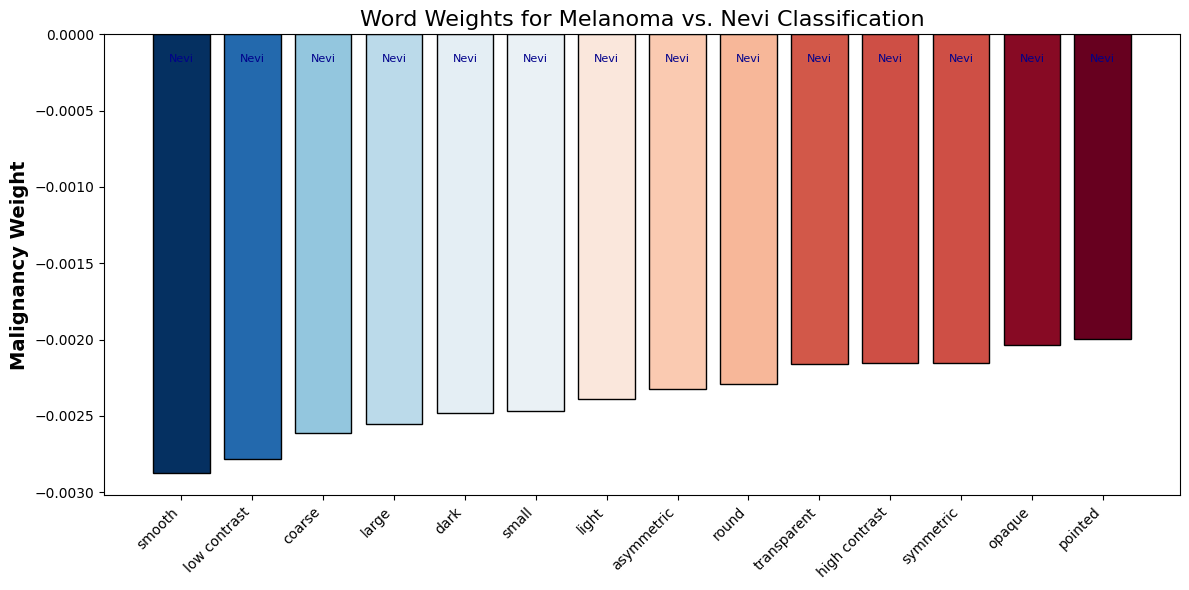

Finding prototypical examples for each word...

Top words for Melanoma:
- pointed
- opaque
- symmetric

Top words for Nevi (benign):
- smooth
- low contrast
- coarse

Displaying prototypical examples for top words...

--- Results with extended words (including skin-specific terms) ---
Training vision-based classifier...
Encoding words with CLIP...
Estimating classifier as linear combination of words...
Test accuracy: 0.917
Test AUC: 0.938
Cosine similarity between actual and estimated classifier weights: 0.023


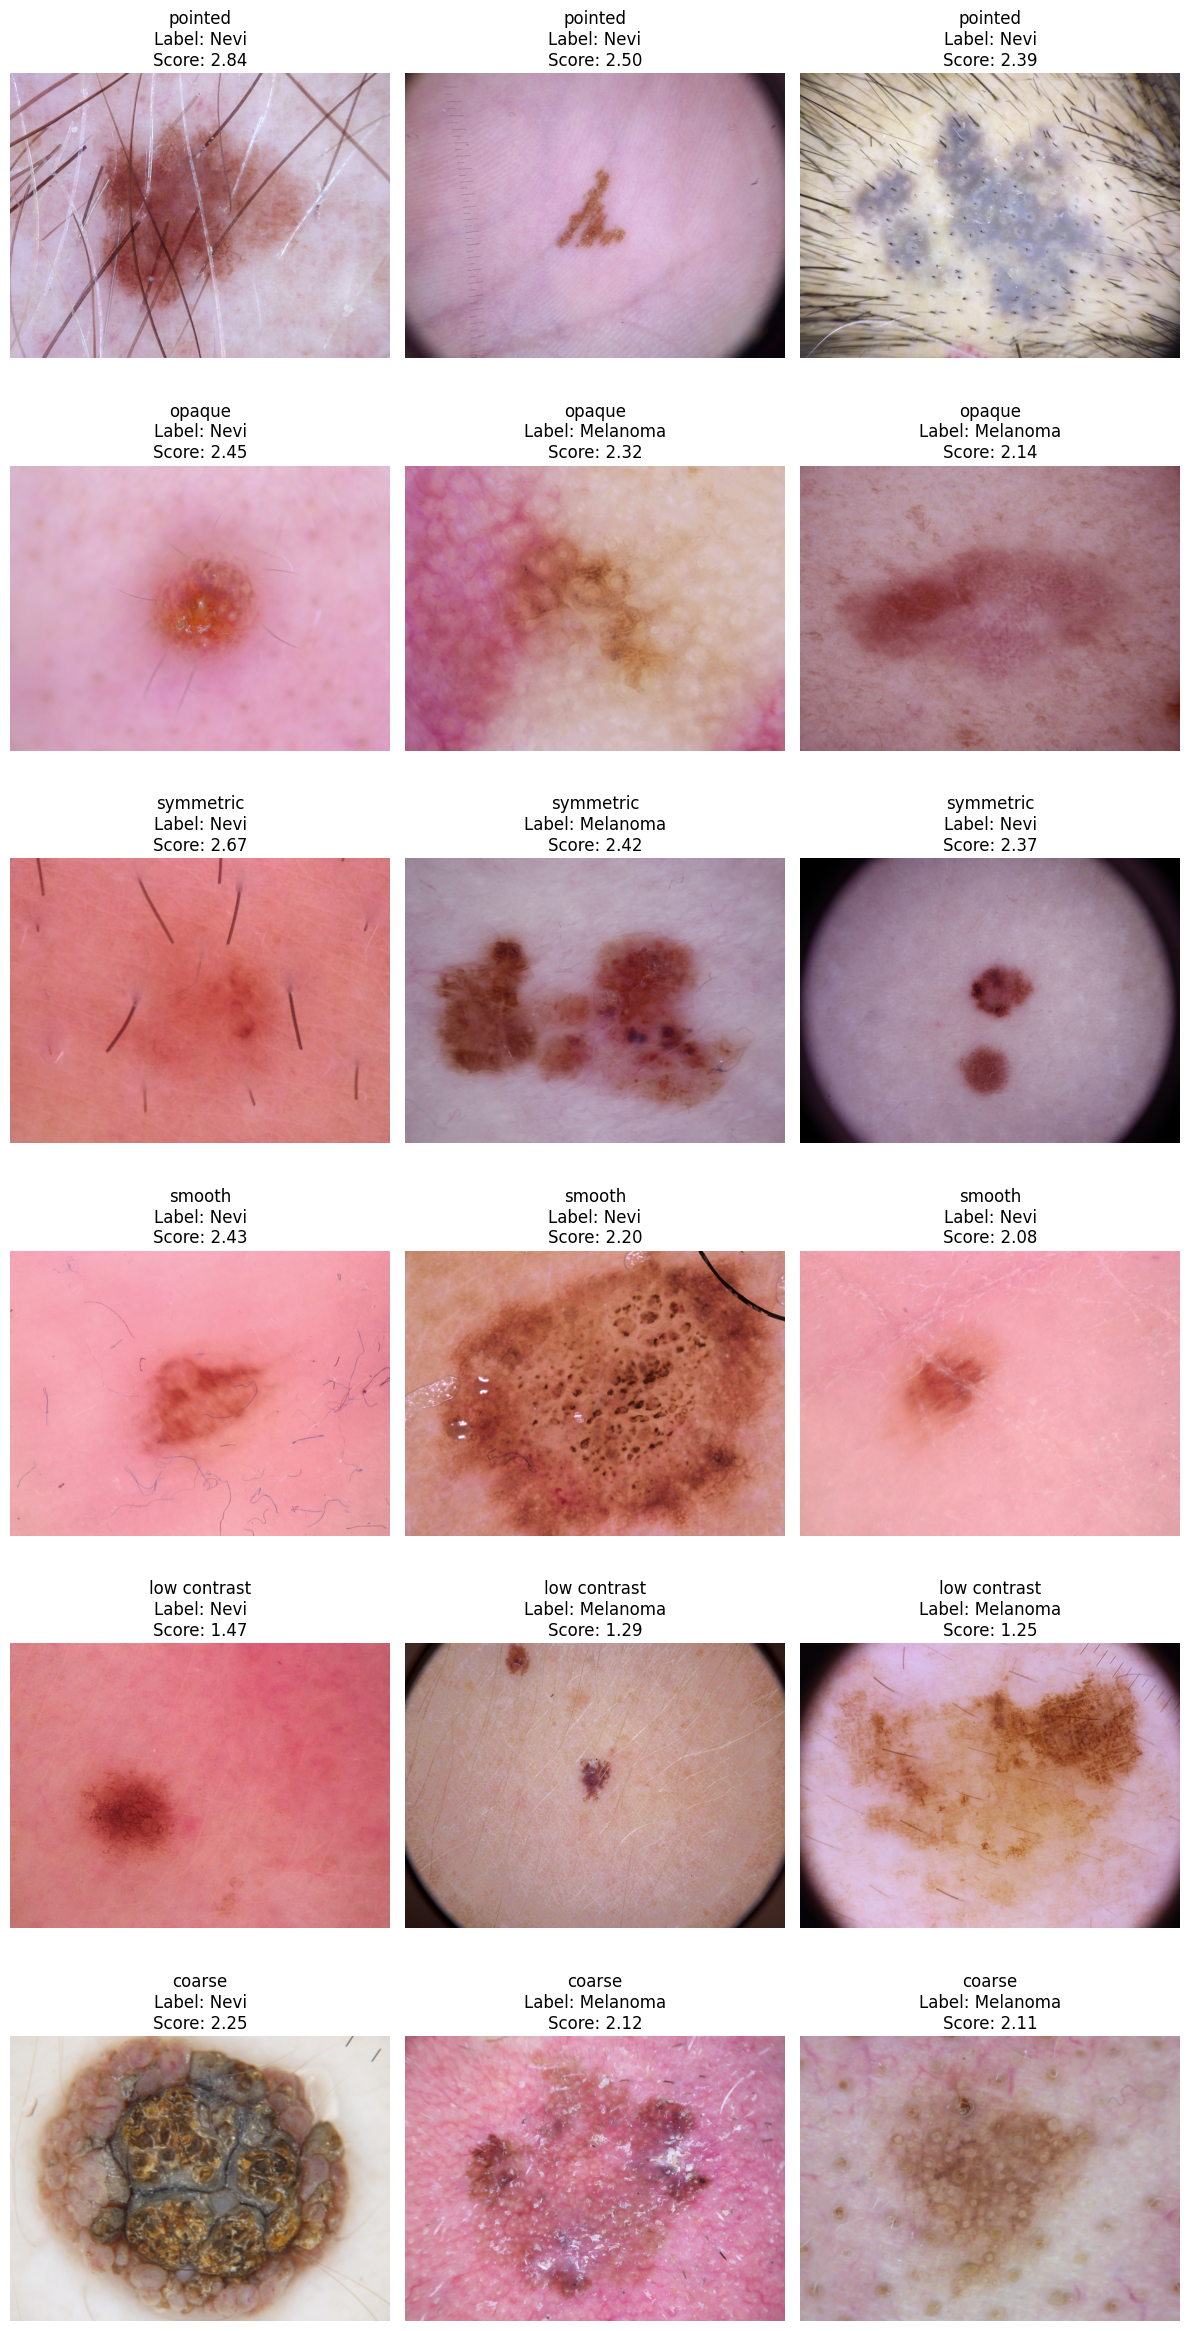

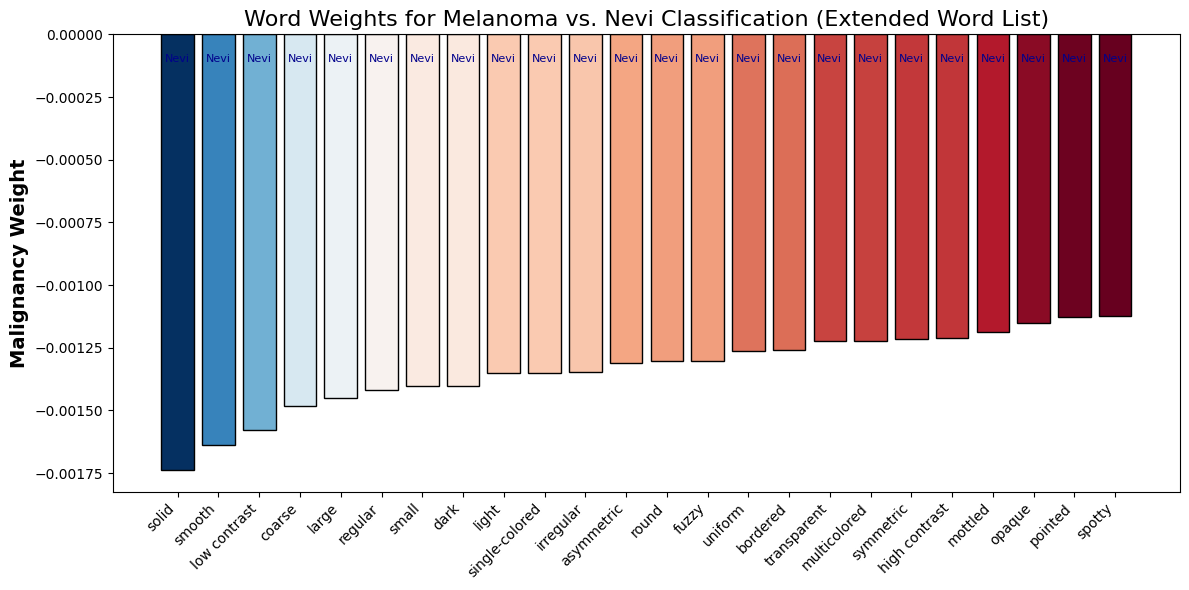


Top extended words for Melanoma:
- spotty
- pointed
- opaque
- mottled
- high contrast

Top extended words for Nevi (benign):
- solid
- smooth
- low contrast
- coarse
- large


In [ ]:
# Run the main function
if __name__ == "__main__":
    results = main()